In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
from stop_words import get_stop_words
import re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

from wordcloud import WordCloud, STOPWORDS




In [2]:
df=pd.read_csv('spam.csv',encoding='latin-1')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
df=df.rename(columns = {'label':'Class','label_num':'Label'})

In [5]:
df

,Class,text,Label
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


In [6]:
df=df[:100]

In [7]:
df.shape

(100, 3)

In [8]:
df.groupby('Class').describe(include='O')

text                                                               
      count unique                                                top freq
Class                                                                     
ham      73     73  Subject: enron methanol ; meter # : 988291\r\n...    1
spam     27     27  Subject: photoshop , windows , office . cheap ...    1

<AxesSubplot:xlabel='Class', ylabel='count'>

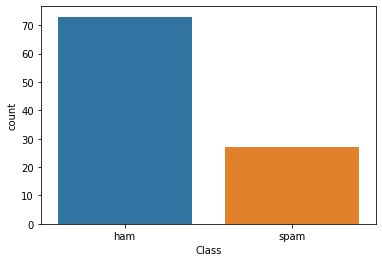

In [9]:
sns.countplot(data=df,x='Class')

In [10]:
Ham_texts=df.query("Class=='ham'")['text']
Spam_texts=df.query("Class=='spam'")['text']

In [11]:
Ham_texts

0     Subject: enron methanol ; meter # : 988291\r\n...
1     Subject: hpl nom for january 9 , 2001\r\n( see...
2     Subject: neon retreat\r\nho ho ho , we ' re ar...
4     Subject: re : indian springs\r\nthis deal is t...
5     Subject: ehronline web address change\r\nthis ...
                            ...                        
89    Subject: quack\r\n( see attached file : duck h...
95    Subject: take 30 % off with our super ticket !...
96    Subject: updated list\r\nvalero deals have now...
97    Subject: hpl nom for march 27 , 2001\r\n( see ...
99    Subject: mobil beaumont\r\nbrian nichols of ex...
Name: text, Length: 73, dtype: object

In [12]:
def words_cleaner(data):
    words=[re.sub('[^a-zA-Z]',' ',i) for i in df['text']]
    words=[i.lower() for j in data for i in j.split()]
    words=[i for i in words if not i in set(stopwords.words('english'))]
    words=[i for i in words if len(i)>2]
    return words

In [13]:
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [14]:
Ham_texts=df.query("Class=='ham'")['text']
ham_words=words_cleaner(Ham_texts)
ham_words_freq=nltk.FreqDist(ham_words)
ham_words_freq=pd.DataFrame(ham_words_freq.most_common(10),columns=['Top_Words','Frequency'])

In [15]:
ham_words_freq

,Top_Words,Frequency
0,ect,172
1,com,157
2,enron,128
3,hou,90
4,subject:,73
5,2000,70
6,mail,68
7,gas,54
8,hpl,50
9,subject,47


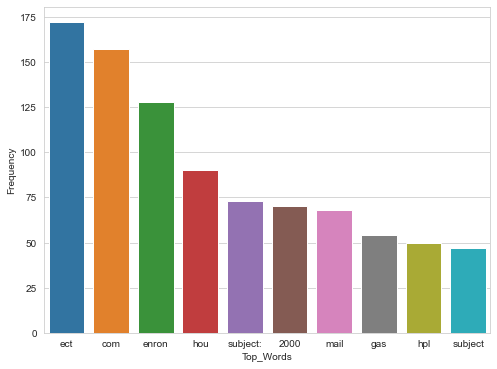

In [16]:
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax=sns.barplot(x='Top_Words',y='Frequency',data=ham_words_freq)

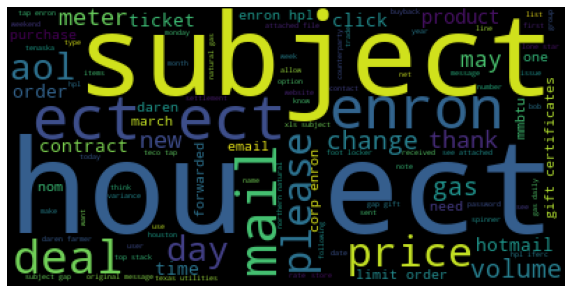

In [17]:
wc(ham_words,'black')

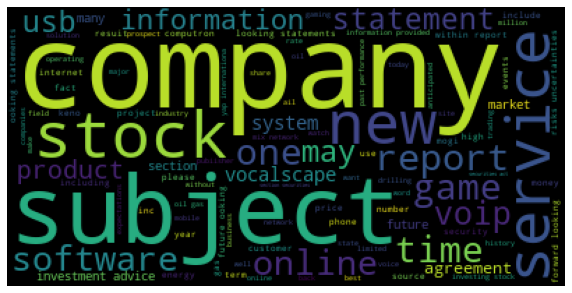

In [18]:
wc(words_cleaner(Spam_texts),'black')

In [19]:
def features_cleaner(data):
    clean_txt=[]
    for i in range(0,len(data)):
        text=re.sub('[^a-zA-Z]',' ',data[i])
        text=text.lower()
        text=text.split()
        ps=PorterStemmer()
        text=[ps.stem(j) for j in text if not j in set(stopwords.words('english'))]
        text=' '.join(text)
        clean_txt.append(text)
    return clean_txt

In [20]:
X=features_cleaner(df['text'])
y=df['Label']

In [21]:
for i in range(0,3):
    print(df['text'][i])
print('***************************      after cleaning        **************')
for i in range(0,3):
    print( X[i] )

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .
Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls
Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .
on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 - 6 . but because of a youth ministers conference that brad and dustin are conne

In [22]:
cv=CountVectorizer()
X=cv.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=51)

In [23]:
cl=MultinomialNB()
cl.fit(X_train,y_train)
y_pred=cl.predict(X_test)

In [24]:
cf_matrix=confusion_matrix(y_test,y_pred)
cf_matrix


array([[19,  0],
       [ 1,  5]], dtype=int64)

<AxesSubplot:>

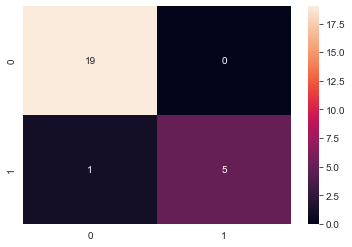

In [25]:
sns.heatmap(cf_matrix,annot=True)

In [26]:
accuracy_score(y_pred,y_test)

0.96

In [27]:
from sklearn.ensemble import RandomForestClassifier
r=RandomForestClassifier()
from sklearn.tree import DecisionTreeClassifier
d=DecisionTreeClassifier()

In [28]:
r.fit(X_train,y_train)
y_pred=r.predict(X_test)

In [29]:
r_matrix=confusion_matrix(y_test,y_pred)
r_matrix

array([[19,  0],
       [ 6,  0]], dtype=int64)

<AxesSubplot:>

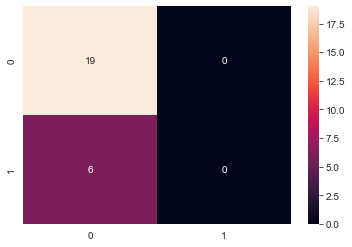

In [30]:
sns.heatmap(r_matrix,annot=True)

In [31]:
d.fit(X_train,y_train)
y_pred=r.predict(X_test)

In [32]:
d_matrix=confusion_matrix(y_test,y_pred)
d_matrix

array([[19,  0],
       [ 6,  0]], dtype=int64)

<AxesSubplot:>

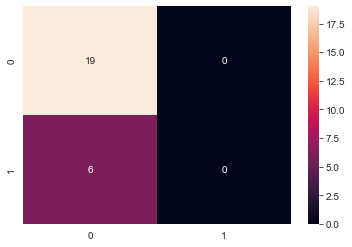

In [33]:
sns.heatmap(d_matrix,annot=True)